# EDA: Demanda de bicicletas compartidas en Seúl

## 1. Contexto y propósito del análisis

En muchas ciudades, los sistemas de bicicletas compartidas se han convertido en una alternativa de transporte flexible, económica y relativamente sostenible. Sin embargo, su operación es un reto: la demanda cambia según la hora del día, el día de la semana, la estación del año y las condiciones meteorológicas. 

El objetivo de este análisis exploratorio de datos (EDA) es **entender cómo se comporta la demanda de bicicletas en Seúl a lo largo del tiempo** y **cómo se relaciona con las variables de clima y calendario**, como paso previo a la construcción de modelos de predicción.

---

## 2. Descripción general del dataset

Trabajaremos con el dataset **“Seoul Bike Sharing Demand”**, que contiene:

- Registros **por hora** de la cantidad de bicicletas rentadas en el sistema público de Seúl.
- Un horizonte aproximado de **un año de datos** (alrededor de 8,7k observaciones).
- Una variable objetivo principal:
  - `Rented Bike Count`: número de bicicletas rentadas en esa hora.
- Variables explicativas que incluyen:
  - **Fecha y tiempo**: fecha, hora, estación del año, indicador de día festivo, indicador de día funcional.
  - **Clima**: temperatura, humedad, velocidad del viento, visibilidad, punto de rocío, radiación solar, lluvia, nieve.

Este EDA se centrará en comprender estas variables, su distribución y sus relaciones con la demanda de bicicletas.

---

## 3. Objetivos específicos del EDA

En esta fase exploratoria buscaremos:

1. **Conocer la estructura básica del dataset**
   - Número de filas y columnas.
   - Tipos de datos por variable.
   - Presencia de valores nulos o atípicos.

2. **Explorar la variable objetivo**
   - Distribución del `Rented Bike Count`.
   - Patrones de demanda por:
     - Hora del día.
     - Día festivo vs. no festivo.
     - Estación del año.
     - Día funcional vs. no funcional (si aplica).

3. **Analizar la relación entre clima y demanda**
   - Cómo varía la demanda con la temperatura.
   - Efecto de la lluvia, la nieve y la humedad.
   - Posibles umbrales (ej. temperaturas “cómodas” vs. extremas).

4. **Identificar patrones temporales**
   - Tendencias diarias y semanales.
   - Diferencias entre estaciones.
   - Horas punta de uso.

---

## 4. Preguntas guía

Algunas preguntas que orientarán el EDA:

- ¿En qué horarios se concentra la mayor demanda de bicicletas?
- ¿Qué estaciones del año muestran mayor o menor uso del sistema?
- ¿Cómo se comporta la demanda en días festivos frente a días laborales?
- ¿Cuál es el impacto de la temperatura y la lluvia en la cantidad de bicicletas rentadas?
- ¿Existen valores atípicos (picos inusuales de demanda) y a qué condiciones están asociados?

---

## 5. Resultado esperado del EDA

Al finalizar esta exploración deberíamos tener:

- Una **visión clara de la calidad de los datos** (nulos, outliers, tipos).
- Una **comprensión intuitiva de la dinámica de la demanda** de bicicletas en Seúl.
- Hipótesis iniciales sobre **qué variables podrían ser más relevantes** para modelos de predicción (por ejemplo, modelos de regresión o series de tiempo).
- Gráficos clave (distribuciones, series temporales, comparaciones por clima/estación) que servirán como base para el modelado posterior.


In [1]:
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal, ttest_ind, mannwhitneyu

# Carpeta donde está la notebook (si ejecutas jupyter desde notebooks/)
NOTEBOOK_DIR = Path().resolve()

# Raíz del proyecto (un nivel arriba)
ROOT_DIR = NOTEBOOK_DIR.parent

# Ruta al CSV
csv_path = ROOT_DIR / "SeoulBikeData.csv"

bikes_df = pd.read_csv(csv_path, encoding="latin1")
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [2]:
def resumen_dataset(df: pd.DataFrame, nombre: str = "DataFrame"):
    print("="*80)
    print(f"📊 Resumen general: {nombre}")
    print("="*80)

    # Dimensiones
    print("\n🔹 Dimensiones (filas, columnas):")
    print(df.shape)

    # Columnas
    print("\n🔹 Columnas:")
    print(df.columns.tolist())

    # Tipos de datos
    print("\n🔹 Tipos de datos:")
    print(df.dtypes)

    # Valores perdidos
    print("\n🔹 Valores perdidos por columna:")
    print(df.isnull().sum().sort_values(ascending=False))

    # Vista rápida de los primeros registros
    print("\n🔹 Primeras filas (head):")
    display(df.head())

    # Vista rápida de algunas filas aleatorias
    print("\n🔹 Muestra aleatoria de 5 filas:")
    display(df.sample(5, random_state=42))

    # Descripción de variables numéricas
    print("\n🔹 Descripción estadística (numéricas):")
    display(df.describe())

    # Descripción de variables categóricas (si las hay)
    print("\n🔹 Descripción variables categóricas (object):")
    cat_cols = df.select_dtypes(include=["object", "category"])
    if not cat_cols.empty:
        display(cat_cols.describe())
    else:
        print("No hay columnas categóricas de tipo object/category.")

    # Info general
    print("\n🔹 Info completa del DataFrame:")
    print("-"*80)
    df.info()

# Llamada de ejemplo (asumiendo que ya cargaste bikes_df):
resumen_dataset(bikes_df, nombre="Seoul Bike Sharing Demand")

📊 Resumen general: Seoul Bike Sharing Demand

🔹 Dimensiones (filas, columnas):
(8760, 14)

🔹 Columnas:
['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']

🔹 Tipos de datos:
Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

🔹 Valores perdidos por columna:
Date                         0
Rented Bike Count            0
Hour     

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes



🔹 Muestra aleatoria de 5 filas:


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
6056,10/08/2018,1728,8,27.2,69,1.8,1999,21.0,0.70,0.0,0.0,Summer,No Holiday,Yes
5556,20/07/2018,822,12,32.6,51,2.1,800,21.1,3.21,0.0,0.0,Summer,No Holiday,Yes
5990,07/08/2018,658,14,34.0,50,1.2,1744,22.1,1.68,0.0,0.0,Summer,No Holiday,Yes
7674,16/10/2018,2716,18,16.9,47,1.4,1637,5.5,0.11,0.0,0.0,Autumn,No Holiday,Yes
3319,18/04/2018,1083,7,6.4,51,1.0,1398,-3.0,0.19,0.0,0.0,Spring,No Holiday,Yes



🔹 Descripción estadística (numéricas):


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000



🔹 Descripción variables categóricas (object):


,Date,Seasons,Holiday,Functioning Day
count,8760,8760,8760,8760
unique,365,4,2,2
top,01/12/2017,Spring,No Holiday,Yes
freq,24,2208,8328,8465



🔹 Info completa del DataFrame:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   obje

## Limpieza inicial de columnas e identificación de variables categóricas

Antes de profundizar en el análisis, es importante:

1. **Estandarizar los nombres de las columnas**  
   - Pasarlos a minúsculas.
   - Eliminar espacios en blanco al inicio y al final.
   - Sustituir espacios y caracteres especiales por guiones bajos (`snake_case`).
   
   Esto facilita el trabajo posterior (evita errores por mayúsculas/acentos/espacios) y vuelve el código más legible.

2. **Identificar variables categóricas**  
   - Las columnas de tipo `object` suelen ser categóricas (por ejemplo: estaciones del año, festivos, tipo de día, etc.).
   - También puede haber columnas numéricas con pocos valores distintos (por ejemplo, 0/1, códigos de categoría), que en la práctica se comportan como categorías.

En este paso vamos a:
- Renombrar todas las columnas a un formato coherente (`snake_case`).
- Detectar columnas candidatas a ser categóricas (por tipo de dato y por número de valores únicos).
- Revisar una muestra de sus valores para confirmar si efectivamente deben tratarse como categorías.


In [3]:
# 1. Función para limpiar y estandarizar nombres de columnas
def clean_column_name(col_name: str) -> str:
    # Quitar espacios al inicio y al final
    col = col_name.strip()
    # Pasar a minúsculas
    col = col.lower()
    # Reemplazar espacios y guiones por guiones bajos
    col = re.sub(r"[ \-]+", "_", col)
    # Eliminar paréntesis y otros caracteres problemáticos
    col = re.sub(r"[()/%]", "", col)
    # Reemplazar múltiples guiones bajos seguidos por uno solo
    col = re.sub(r"_+", "_", col)
    # Quitar guiones bajos al inicio o al final, si quedaron
    col = col.strip("_")
    return col

# 2. Aplicar la limpieza a todas las columnas
bikes_df.columns = [clean_column_name(c) for c in bikes_df.columns]

print("✅ Nuevos nombres de columnas:")
print(bikes_df.columns.tolist())

# 3. Identificar columnas candidatas a categóricas

def detectar_categoricas(df: pd.DataFrame, max_nunique_num=20, frac_umbral=0.05):
    """
    - max_nunique_num: máximo de valores únicos para considerar una numérica como categórica.
    - frac_umbral: proporción máxima de valores únicos respecto al total de filas
                   para considerar una numérica como categórica.
    """
    n_rows = len(df)
    
    print("\n🔹 Columnas de tipo 'object' (candidatas categóricas):")
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if obj_cols:
        for col in obj_cols:
            nunique = df[col].nunique(dropna=False)
            print(f"  - {col} (nunique={nunique})")
        print("\nEjemplo de valores por columna object:")
        for col in obj_cols:
            print(f"\n▶ {col}:")
            print(df[col].value_counts(dropna=False).head())
    else:
        print("  No hay columnas de tipo object.")
    
    print("\n🔹 Columnas numéricas con pocos valores únicos (posibles categorías codificadas):")
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    cat_num_cols = []
    
    for col in num_cols:
        nunique = df[col].nunique(dropna=False)
        frac_unique = nunique / n_rows if n_rows > 0 else 0
        if (nunique <= max_nunique_num) or (frac_unique <= frac_umbral):
            cat_num_cols.append((col, nunique, frac_unique))
    
    if cat_num_cols:
        for col, nunique, frac_unique in cat_num_cols:
            print(f"  - {col}: nunique={nunique}, frac_unique={frac_unique:.4f}")
            print(df[col].value_counts(dropna=False).head())
            print("-" * 60)
    else:
        print("  No se detectaron numéricas con baja cardinalidad.")

# 4. Ejecutar la detección de categóricas
detectar_categoricas(bikes_df, max_nunique_num=20, frac_umbral=0.05)


✅ Nuevos nombres de columnas:
['date', 'rented_bike_count', 'hour', 'temperature°c', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temperature°c', 'solar_radiation_mjm2', 'rainfallmm', 'snowfall_cm', 'seasons', 'holiday', 'functioning_day']

🔹 Columnas de tipo 'object' (candidatas categóricas):
  - date (nunique=365)
  - seasons (nunique=4)
  - holiday (nunique=2)
  - functioning_day (nunique=2)

Ejemplo de valores por columna object:

▶ date:
date
01/12/2017    24
02/12/2017    24
03/12/2017    24
04/12/2017    24
05/12/2017    24
Name: count, dtype: int64

▶ seasons:
seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64

▶ holiday:
holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64

▶ functioning_day:
functioning_day
Yes    8465
No      295
Name: count, dtype: int64

🔹 Columnas numéricas con pocos valores únicos (posibles categorías codificadas):
  - hour: nunique=24, frac_unique=0.0027
hour
0    365
1    365
2 

## Ajuste de tipos de datos (datetime, categóricas y binarias)

A partir de la inspección inicial del dataset, identificamos las siguientes columnas cuya naturaleza es clara y conviene tipar de forma explícita:

- `date`: actualmente está como texto (`object`), pero representa una **fecha**. La convertiremos a tipo `datetime`, respetando el formato `dd/mm/yyyy`.
- `seasons`: tiene 4 valores (`Spring`, `Summer`, `Autumn`, `Winter`), por lo que es claramente una **variable categórica nominal**.
- `holiday`: con valores `Holiday` y `No Holiday`, se trata de una **variable binaria** que indica si el día es festivo o no. La convertiremos a `category` y, opcionalmente, crearemos una versión codificada como 0/1.
- `functioning_day`: con valores `Yes` y `No`, es otra **variable binaria** que indica si el sistema estaba en operación. También la convertiremos a `category` y podemos crear una versión 0/1.

Por ahora, mantendremos las demás columnas numéricas (como `hour`, `humidity`, etc.) en tipo numérico, aunque algunas podrían interpretarse como categóricas en análisis posteriores. Más adelante, según lo que observemos en el EDA, podremos reconsiderar su tratamiento (por ejemplo, tratar `hour` como categoría o como componente temporal cíclico).


In [4]:
# 1. Convertir la columna de fecha a datetime
# El formato en el dataset es dd/mm/yyyy (ejemplo: 01/12/2017)
bikes_df["date"] = pd.to_datetime(bikes_df["date"], format="%d/%m/%Y")

# 2. Convertir columnas claramente categóricas a dtype 'category'
cat_cols = ["seasons", "holiday", "functioning_day"]
for col in cat_cols:
    bikes_df[col] = bikes_df[col].astype("category")

# 3. Crear versiones binarias (0/1) para holiday y functioning_day (opcional pero útil)
bikes_df["is_holiday"] = (
    bikes_df["holiday"]
    .map({"Holiday": 1, "No Holiday": 0})
    .astype("int8")
)

bikes_df["is_functioning_day"] = (
    bikes_df["functioning_day"]
    .map({"Yes": 1, "No": 0})
    .astype("int8")
)

# 4. Verificación rápida de tipos
print("🔹 Tipos de datos después del ajuste:\n")
print(bikes_df.dtypes)

print("\n🔹 Comprobación de categorías y binarios:\n")
for col in ["seasons", "holiday", "functioning_day", "is_holiday", "is_functioning_day"]:
    print(f"▶ {col}")
    print(bikes_df[col].value_counts(dropna=False))
    print("-" * 40)


🔹 Tipos de datos después del ajuste:

date                       datetime64[ns]
rented_bike_count                   int64
hour                                int64
temperature°c                     float64
humidity                            int64
wind_speed_ms                     float64
visibility_10m                      int64
dew_point_temperature°c           float64
solar_radiation_mjm2              float64
rainfallmm                        float64
snowfall_cm                       float64
seasons                          category
holiday                          category
functioning_day                  category
is_holiday                           int8
is_functioning_day                   int8
dtype: object

🔹 Comprobación de categorías y binarios:

▶ seasons
seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64
----------------------------------------
▶ holiday
holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64
------

## Búsqueda de duplicados (explícitos y lógicos)

Antes de empezar a agrupar y resumir información, es importante verificar si el dataset contiene **registros duplicados**, ya que estos pueden sesgar los conteos y las estadísticas.

En este análisis distinguiremos dos tipos de duplicados:

1. **Duplicados explícitos**  
   Filas que son idénticas en **todas** las columnas (mismo valor en cada variable).  
   - Estos suelen aparecer por errores de carga o integración de datos.
   - Se detectan con `DataFrame.duplicated()` sin especificar columnas.

2. **Duplicados lógicos**  
   Filas que no son idénticas en todas las columnas, pero representan **la misma entidad en el tiempo**.  
   En este dataset, asumiremos que la “unidad lógica” de observación es el par:
   - `date` + `hour`  
   Es decir, para cada combinación de fecha y hora debería haber, como máximo, un registro.  
   - Si encontramos más de una fila con el mismo `date` y `hour`, lo consideraremos un posible duplicado lógico.

En este paso sólo **detectaremos y resumiremos** estos duplicados.  
Las decisiones de eliminación, agregación o corrección se tomarán después, con base en lo que encontremos.


In [5]:
# 1. Información básica
n_rows_before = len(bikes_df)
print(f"🔹 Número total de filas: {n_rows_before}")

# 2. Duplicados explícitos (todas las columnas iguales)
dup_explicit_mask = bikes_df.duplicated(keep=False)  # keep=False marca todos los duplicados, no solo a partir del segundo
dup_explicit = bikes_df[dup_explicit_mask]

n_dup_explicit_grupos = bikes_df.duplicated().sum()  # filas consideradas duplicadas (manteniendo la primera)
n_dup_explicit_total = len(dup_explicit)

print("\n==============================================")
print("🔍 Duplicados explícitos (todas las columnas):")
print("==============================================")
print(f"- Filas marcadas como duplicadas (excepto la primera de cada grupo): {n_dup_explicit_grupos}")
print(f"- Filas totales involucradas en filas duplicadas (incluyendo la primera): {n_dup_explicit_total}")

if n_dup_explicit_total > 0:
    print("\nEjemplo de duplicados explícitos:")
    display(dup_explicit.head())
else:
    print("No se encontraron duplicados explícitos.")

# 3. Duplicados lógicos por clave (date + hour)
clave_logica = ["date", "hour"]

dup_logical_mask = bikes_df.duplicated(subset=clave_logica, keep=False)
dup_logical = bikes_df[dup_logical_mask].sort_values(clave_logica)

n_dup_logical_filas = len(dup_logical)

print("\n===========================================")
print("🔍 Duplicados lógicos por clave date + hour")
print("===========================================")
print(f"- Filas que comparten la misma clave lógica (date + hour): {n_dup_logical_filas}")

if n_dup_logical_filas > 0:
    print("\nGrupos de posibles duplicados lógicos (conteo por combinación date + hour):")
    display(
        dup_logical
        .groupby(clave_logica)
        .size()
        .reset_index(name="n_registros")
        .sort_values("n_registros", ascending=False)
        .head(10)
    )

    print("\nEjemplo de filas con la misma clave lógica (date + hour):")
    display(dup_logical.head(10))
else:
    print("No se encontraron duplicados lógicos para la clave (date + hour).")

# 4. Resumen general
print("\n===========================================")
print("📋 Resumen de duplicados")
print("===========================================")
print(f"- Total de filas: {n_rows_before}")
print(f"- Filas en grupos de duplicados explícitos: {n_dup_explicit_total}")
print(f"- Filas en posibles duplicados lógicos (date + hour): {n_dup_logical_filas}")


🔹 Número total de filas: 8760

🔍 Duplicados explícitos (todas las columnas):
- Filas marcadas como duplicadas (excepto la primera de cada grupo): 0
- Filas totales involucradas en filas duplicadas (incluyendo la primera): 0
No se encontraron duplicados explícitos.

🔍 Duplicados lógicos por clave date + hour
- Filas que comparten la misma clave lógica (date + hour): 0
No se encontraron duplicados lógicos para la clave (date + hour).

📋 Resumen de duplicados
- Total de filas: 8760
- Filas en grupos de duplicados explícitos: 0
- Filas en posibles duplicados lógicos (date + hour): 0


## Conclusión sobre observaciones duplicadas

Como parte de la limpieza inicial, se realizó una búsqueda de:

1. **Duplicados explícitos**  
   Filas completamente idénticas en todas las columnas.

2. **Duplicados lógicos**  
   Filas que comparten la misma clave lógica `date + hour`, es decir, múltiples registros para la misma combinación de fecha y hora.

Los resultados del análisis fueron los siguientes:

- **Duplicados explícitos:** no se encontraron filas que estuvieran repetidas en todas sus columnas.
- **Duplicados lógicos (`date + hour`):** no se detectaron combinaciones de fecha y hora con más de un registro asociado.

En resumen, **no se identificaron observaciones duplicadas**, ni a nivel explícito ni lógico, por lo que el conjunto de datos puede considerarse consistente en cuanto a unicidad de registros y está listo para avanzar hacia etapas de agregación, análisis temporal y exploración de relaciones entre variables.


## Análisis de la demanda por estación del año y hora del día

Una vez realizada la limpieza básica del dataset (tipos de datos, categorías y verificación de duplicados), el siguiente paso es explorar **cómo varía la demanda de bicicletas (`rented_bike_count`) a lo largo del tiempo**.

En particular, nos interesa:

1. **Estación del año (`seasons`)**  
   - Comparar la demanda promedio y mediana entre *Spring, Summer, Autumn, Winter*.
   - Identificar en qué estación se alcanzan los valores más altos y más bajos de renta.

2. **Hora del día (`hour`)**  
   - Analizar el patrón diario de uso: horas valle y horas pico.
   - Ver si la forma del “perfil diario” parece consistente (e.g. picos en mañana y tarde).

3. **Combinación estación × hora (`seasons` + `hour`)**  
   - Ver cómo se distribuye la demanda por hora dentro de cada estación.
   - Detectar horarios especialmente fuertes o débiles en ciertas estaciones (por ejemplo, tardes de verano).

En esta sección agruparemos los datos por estos ejes y calcularemos estadísticas descriptivas (media, mediana, mínimos y máximos) de la demanda. Más adelante, sobre estas mismas agrupaciones, incorporaremos variables de clima (temperatura, humedad, viento, etc.) para entender mejor qué factores están asociados con los niveles altos o bajos de uso.


In [6]:
# Resumen de la demanda por estación
season_demand_summary = (
    bikes_df
    .groupby("seasons")["rented_bike_count"]
    .agg(["count", "mean", "median", "min", "max"])
    .sort_values("mean", ascending=False)
)

print("🔹 Resumen de demanda por estación del año:")
display(season_demand_summary)


🔹 Resumen de demanda por estación del año:


/tmp/ipykernel_107766/3555711185.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("seasons")["rented_bike_count"]


,count,mean,median,min,max
seasons,,,,,
Summer,2208,1034.073370,905.5,9,3556
Autumn,2184,819.597985,763.5,0,3298
Spring,2208,730.031250,583.0,0,3251
Winter,2160,225.541204,203.0,3,937


A partir del resumen por estación, se observa que la demanda promedio de bicicletas es claramente más alta en **verano**, seguida por **otoño**, luego **primavera**, mientras que el **invierno** concentra los niveles más bajos de renta. En términos generales, esto sugiere que un “día típico” de verano ofrece las condiciones más favorables para el uso del sistema de bicicletas compartidas, al menos desde el punto de vista del volumen de uso observado en los datos.


In [7]:
# Resumen de la demanda por hora del día
hour_demand_summary = (
    bikes_df
    .groupby("hour")["rented_bike_count"]
    .agg(["count", "mean", "median", "min", "max"])
    .sort_values("hour" if "hour" in bikes_df.columns else "mean", ascending=True)
)

print("🔹 Resumen de demanda por hora del día:")
display(hour_demand_summary)


🔹 Resumen de demanda por hora del día:


,count,mean,median,min,max
hour,,,,,
0,365,541.460274,513.0,0,1394
1,365,426.183562,401.0,0,1088
2,365,301.630137,265.0,0,1254
3,365,203.331507,176.0,0,644
4,365,132.591781,119.0,0,421
5,365,139.082192,129.0,0,383
6,365,287.564384,232.0,0,807
7,365,606.005479,426.0,0,1629
8,365,1015.701370,728.0,0,2495


A partir del resumen por hora del día, se observa un patrón muy marcado de valle nocturno y pico vespertino. La hora con menor demanda promedio es las **04:00**, con alrededor de 130 rentas por hora en promedio, mientras que la hora con mayor demanda promedio es las **18:00**, con más de **1500** rentas por hora. Además, las 18:00 también concentran el valor máximo observado en todo el año (3556 rentas en una sola hora), lo que confirma que esta franja representa el pico absoluto de uso del sistema. Por otro lado, aunque el valor mínimo registrado es 0 en todas las horas (todas las horas tienen al menos algún día sin rentas), el contraste entre 04:00 y 18:00 ayuda a perfilar claramente las horas valle y las horas pico en la dinámica diaria de la demanda.

En la columna de valores máximos por hora (`max`), se observa que la hora con el pico absoluto de demanda es las **18:00**, donde en su mejor día se registraron **3556** rentas en una sola hora. En el extremo opuesto, la hora cuyo máximo registrado es más bajo es las **05:00**, con un valor máximo de **383** rentas. Esto refuerza la idea de que el verdadero pico de uso se concentra en la franja vespertina, mientras que incluso en su “mejor día” la demanda de las 05:00 se mantiene muy por debajo del resto de horas, alineándose con el valle de actividad de primera hora de la mañana.


/tmp/ipykernel_107766/3501804035.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["seasons", "hour"])["rented_bike_count"]


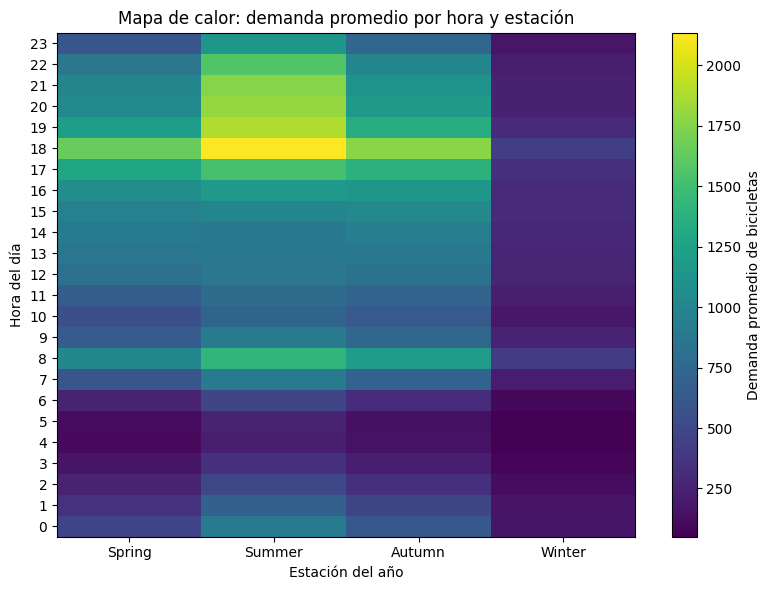

In [8]:
# Resumen de demanda por estación y hora
season_hour_summary = (
    bikes_df
    .groupby(["seasons", "hour"])["rented_bike_count"]
    .agg(["count", "mean", "median", "min", "max"])
    .reset_index()
)

# Pivot: filas = hora, columnas = estación, valores = media de rentas
season_hour_pivot_mean = season_hour_summary.pivot(
    index="hour",
    columns="seasons",
    values="mean"
)

# (Opcional) ordenar las estaciones en un orden "natural"
season_order = ["Spring", "Summer", "Autumn", "Winter"]
season_hour_pivot_mean = season_hour_pivot_mean[season_order]

# Mapa de calor
plt.figure(figsize=(8, 6))

im = plt.imshow(
    season_hour_pivot_mean.values,
    aspect="auto",
    origin="lower"  # para que 0 quede abajo
)

plt.colorbar(im, label="Demanda promedio de bicicletas")

# Etiquetas de los ejes
plt.xticks(
    ticks=range(len(season_hour_pivot_mean.columns)),
    labels=season_hour_pivot_mean.columns
)
plt.yticks(
    ticks=range(len(season_hour_pivot_mean.index)),
    labels=season_hour_pivot_mean.index
)

plt.xlabel("Estación del año")
plt.ylabel("Hora del día")
plt.title("Mapa de calor: demanda promedio por hora y estación")

plt.tight_layout()
plt.show()


## Lectura del mapa de calor: demanda por hora y estación

El mapa de calor confirma varios patrones claros en la dinámica diaria y estacional de la demanda:

- **Verano domina en casi todas las horas**:  
  La columna de *Summer* es, en general, la más brillante. Entre las **06:00 y las 10:00** la demanda es claramente más alta que en las demás estaciones, y en el bloque de la tarde–noche (especialmente **18:00–21:00**) se observan los valores más intensos de todo el mapa. Esto refuerza la idea de que el verano es la estación con mayor uso general del sistema.

- **Horas pico muy marcadas: 08:00 y 18:00**  
  En todas las estaciones se aprecia que las **08:00** y las **18:00** son horarios especialmente concurridos, aunque en verano el contraste es mucho más fuerte.  
  - A las **08:00** el patrón sugiere un uso asociado al **inicio de la jornada** (desplazamientos al trabajo, escuela, etc.).  
  - A las **18:00** se observa el pico vespertino clásico, compatible con **salida del trabajo** y actividades posteriores.

- **Valle nocturno y madrugadas débiles**  
  Entre las **03:00 y las 05:00** el mapa se oscurece en todas las estaciones. Son las horas con menor intensidad de color, coherente con los promedios más bajos de demanda. Incluso en verano, donde persiste algo de actividad, estas horas se mantienen como el valle más profundo del día.

- **Invierno como estación de baja demanda**  
  La columna de *Winter* es, en casi todos los horarios, la más oscura.  
  - Solo en torno a las **08:00** y las **18:00** se ve una ligera “franja” más brillante, indicando que incluso en invierno se conservan ciertos patrones de movilidad obligada (traslados formales).  
  - El resto de las horas se mantienen en niveles mucho más bajos que los observados en verano, lo que sugiere que el frío, la nieve y las condiciones climáticas adversas reducen fuertemente el uso recreativo o discrecional.

- **Franja de uso sostenido al mediodía (12:00–16:00)**  
  Entre las **12:00 y las 16:00** se aprecia un nivel relativamente estable de demanda en casi todas las estaciones, con un “extra” de intensidad en verano.  
  Este comportamiento es compatible con perfiles de usuarios que emplean la bicicleta como **medio de transporte funcional** (ir a comer, hacer trámites, desplazamientos laborales dentro de la jornada) más que por ocio.  
  En primavera y otoño esta franja se mantiene, aunque con menor intensidad; en invierno, en cambio, la señal se atenúa de forma notable, lo que refuerza la hipótesis de que el mal clima desincentiva estos desplazamientos intermedios.

En conjunto, el mapa de calor sugiere al menos dos grandes perfiles de uso:
1. **Usuarios “funcionales” o de transporte**: concentrados en las horas de entrada/salida (08:00 y 18:00) y en la franja de 12:00–16:00, presentes en todas las estaciones pero con mayor intensidad en verano.
2. **Uso más recreativo o discrecional**: especialmente visible en verano, donde incluso franjas que en otras estaciones son débiles (por ejemplo, parte del mediodía) muestran un “calor” extra, indicando que las condiciones más agradables amplían el rango horario en el que la gente se anima a usar la bicicleta.


In [9]:
weather_cols = [
    "temperature°c",
    "humidity",
    "wind_speed_ms",
    "visibility_10m",
    "solar_radiation_mjm2",
    "rainfallmm",
    "snowfall_cm",
]

season_with_weather = (
    bikes_df
    .groupby("seasons")[["rented_bike_count"] + weather_cols]
    .mean()
)

display(season_with_weather)


/tmp/ipykernel_107766/4020725424.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("seasons")[["rented_bike_count"] + weather_cols]


,rented_bike_count,temperature°c,humidity,wind_speed_ms,visibility_10m,solar_radiation_mjm2,rainfallmm,snowfall_cm
seasons,,,,,,,,
Autumn,819.597985,14.120833,59.228480,1.494734,1560.752289,0.521818,0.122756,0.056319
Spring,730.031250,13.046694,58.776721,1.874592,1240.364583,0.688786,0.182880,0.000000
Summer,1034.073370,26.582790,64.981431,1.609420,1501.745471,0.761255,0.253487,0.000000
Winter,225.541204,-2.540463,49.744907,1.922685,1445.987037,0.298181,0.032824,0.247500


<Figure size 1000x600 with 0 Axes>

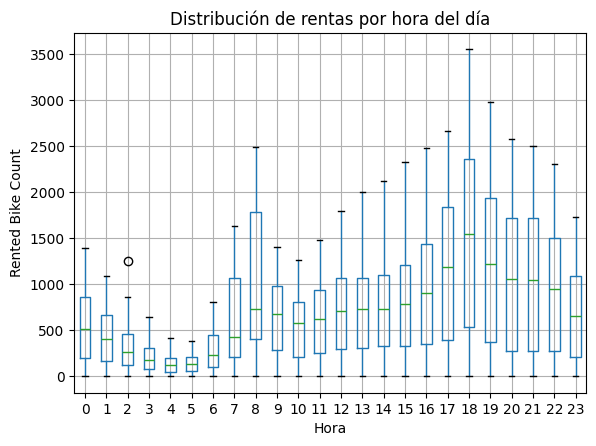

In [10]:
hour_activity = (
    bikes_df
    .groupby("hour")["rented_bike_count"]
    .agg(
        count="count",
        mean="mean",
        median="median",
        min="min",
        max="max",
        zeros=lambda s: (s == 0).sum(),
        non_zeros=lambda s: (s > 0).sum()
    )
)

hour_activity["pct_non_zeros"] = hour_activity["non_zeros"] / hour_activity["count"]

plt.figure(figsize=(10, 6))
bikes_df.boxplot(column="rented_bike_count", by="hour")
plt.title("Distribución de rentas por hora del día")
plt.suptitle("")
plt.xlabel("Hora")
plt.ylabel("Rented Bike Count")
plt.show()


## Preguntas de negocio: clima, estaciones y demanda anómala

“**¿cómo y por qué varía la demanda**?”.

En particular, nos interesan preguntas como:

- **Estacionalidad climática**
  - ¿Qué hace que el verano sea más “disfrutable” para los usuarios?  
    (temperaturas más templadas, menos lluvia, mayor radiación solar, etc.)
  - ¿Qué factores vuelven el invierno menos atractivo para usar bicicletas?

- **Inviernos anómalos o condiciones atípicas**
  - ¿Qué ocurre en invierno cuando las temperaturas son inusualmente cálidas?
  - ¿Se observa un incremento de demanda respecto al “invierno típico”?
  - ¿Podría el sistema anticipar estos periodos atípicos para ajustar mejor la oferta?

- **Altas expectativas vs demanda real**
  - En horas y estaciones donde normalmente hay **alta demanda** (por ejemplo, tardes de verano),  
    ¿qué condiciones (lluvia, nieve, viento fuerte, baja visibilidad, festivos, etc.) provocan que la demanda caiga por debajo de lo esperado?
  - ¿Se pueden identificar “días decepcionantes” para el sistema, donde se esperaría mucho uso pero las condiciones externas lo frenan?

### Estrategia de análisis

Para abordar estas preguntas, seguiremos estos pasos:

1. **Perfilar estaciones con clima y demanda**
   - Agrupar por `seasons` y calcular promedios de:
     - `rented_bike_count`
     - variables de clima: temperatura, humedad, viento, visibilidad, radiación, lluvia, nieve.
   - Comparar el “perfil climático” de cada estación con su nivel medio de demanda.

2. **Identificar inviernos anómalamente cálidos**
   - Dentro de `Winter`, segmentar por rangos de temperatura (cuartiles) y observar cómo cambia la demanda.
   - Comparar “invierno muy frío” vs “invierno relativamente cálido”.

3. **Días y horas con demanda inesperadamente baja**
   - Focalizarnos en horas de alta demanda típica (por ejemplo, 17–21 h).
   - Detectar horas con demanda inusualmente baja (por debajo de un cierto cuantil) y analizar las condiciones de clima y calendario en esos casos.

Este análisis servirá como base no sólo para entender el comportamiento de los usuarios, sino también para imaginar **estrategias operativas**: refuerzo de oferta en periodos anómalos, planes de contingencia ante lluvia/nieve, campañas específicas por estación, etc.


In [11]:
season_profile = (
    bikes_df
    .groupby("seasons")[["rented_bike_count"] + weather_cols]
    .agg(["mean", "median"])
    .round(2)
)

print("🔹 Perfil por estación (demanda + clima):")
display(season_profile)


🔹 Perfil por estación (demanda + clima):


/tmp/ipykernel_107766/2298817367.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("seasons")[["rented_bike_count"] + weather_cols]


rented_bike_count        temperature°c        humidity         \
                     mean median          mean median     mean median   
seasons                                                                 
Autumn             819.60  763.5         14.12  13.85    59.23   59.0   
Spring             730.03  583.0         13.05  13.30    58.78   58.0   
Summer            1034.07  905.5         26.58  26.60    64.98   65.0   
Winter             225.54  203.0         -2.54  -2.20    49.74   47.0   

        wind_speed_ms        visibility_10m         solar_radiation_mjm2  \
                 mean median           mean  median                 mean   
seasons                                                                    
Autumn           1.49    1.3        1560.75  1900.0                 0.52   
Spring           1.87    1.7        1240.36  1307.5                 0.69   
Summer           1.61    1.5        1501.75  1740.5                 0.76   
Winter           1.92    1.7        1445.99  1762.0                 0.30   

               rainfallmm        snowfall_cm         
        median       mean median        mean median  
seasons                                              
Autumn    0.00       0.12    0.0        0.06    0.0  
Spring    0.06       0.18    0.0        0.00    0.0  
Summer    0.16       0.25    0.0        0.00    0.0  
Winter    0.00       0.03    0.0        0.25    0.0

## Perfil por estación: demanda y clima

Del resumen por estación se pueden extraer varios patrones claros:

- **Demanda por estación (rented_bike_count)**  
  - La mayor demanda promedio se observa en **Summer** (~1034 bicis/h), seguida de **Autumn** (~820) y **Spring** (~730).  
  - **Winter** queda muy por debajo (~226), confirmando que es la estación con menor uso del sistema.  
  - En todas las estaciones la mediana es algo menor que la media, lo que sugiere la presencia de algunos días con demanda muy alta (cola derecha).

- **Temperatura y comodidad térmica (temperature°c)**  
  - **Summer** presenta las temperaturas más altas (media ~26.6 °C) y coincide con la mayor demanda: el calor, dentro de estos rangos, parece incentivar el uso de la bici.  
  - **Spring** y **Autumn** tienen temperaturas muy similares (≈13–14 °C), pero **Autumn** muestra más demanda que Spring, lo que sugiere que otros factores además de la temperatura influyen en la diferencia entre ambas estaciones.  
  - **Winter** tiene temperaturas claramente bajo cero en promedio (~–2.5 °C), lo que se asocia con la caída drástica de uso.

- **Humedad, viento y visibilidad (humidity, wind_speed_ms, visibility_10m)**  
  - La **humedad** es más alta en **Summer** (~65 %) y algo inferior en Spring y Autumn (~59 %). En Winter baja aún más (~50 %), lo que indica un frío relativamente seco.  
  - La **velocidad del viento** no varía dramáticamente entre estaciones (≈1.5–1.9 m/s), por lo que no parece ser el factor principal que explica las diferencias de demanda.  
  - La **visibilidad** es alta en todas las estaciones (≈1200–1600, según la unidad del dataset), con valores ligeramente menores en Spring. Autumn y Winter mantienen visibilidades medias relativamente buenas.

- **Radiación solar, lluvia y nieve (solar_radiation_mjm2, rainfallmm, snowfall_cm)**  
  - La **radiación solar** es mayor en **Summer** (~0.76) y también relativamente alta en **Autumn** y **Spring**; en **Winter** es claramente menor (~0.30), lo que coincide con días más cortos y menos luminosos.  
  - La **lluvia** (rainfallmm) es más frecuente o intensa en **Summer** (media ~0.25) y en menor medida en Spring (~0.18), pero esto no impide que el verano siga siendo la estación con mayor demanda, lo que sugiere que el efecto positivo de la temperatura agradable supera el efecto negativo de la lluvia.  
  - La **nieve** (snowfall_cm) aparece prácticamente solo en **Winter** (media ~0.25 cm), y es coherente con la fuerte caída de la demanda: bajas temperaturas y presencia de nieve parecen ser una combinación claramente desfavorable para el uso de bicicletas.

En conjunto, la tabla sugiere que:
- La **combinación de temperaturas templadas o cálidas, buena radiación solar y ausencia de nieve** es el escenario más favorable para el uso de bicicletas (Summer y, en segundo lugar, Autumn).  
- **Winter** se distingue no solo por el frío, sino también por la nieve y menor radiación, lo que se refleja directamente en la menor demanda.  
- Las diferencias entre **Spring** y **Autumn**, pese a tener temperaturas similares, podrían estar relacionadas con ligeras variaciones en lluvia, viento y tal vez patrones de calendario (festivos, hábitos de la población), lo que abre la puerta a análisis más finos por mes o por combinación clima–hora.


In [12]:
winter_df  = bikes_df[bikes_df["seasons"] == "Winter"].copy()
summer_df  = bikes_df[bikes_df["seasons"] == "Summer"].copy()
autumn_df  = bikes_df[bikes_df["seasons"] == "Autumn"].copy()
spring_df  = bikes_df[bikes_df["seasons"] == "Spring"].copy()

daily_df = (
    bikes_df
    .groupby(["seasons", "date"])["rented_bike_count"]
    .sum()
    .reset_index()
    .rename(columns={"rented_bike_count": "daily_rentals"})
)

# Tomando solo una estación, p. ej. Autumn
autumn_daily = daily_df[daily_df["seasons"] == "Autumn"].copy()

q1 = autumn_daily["daily_rentals"].quantile(0.25)

autumn_daily["bad_day"] = (autumn_daily["daily_rentals"] <= q1).astype(int)

/tmp/ipykernel_107766/308242631.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["seasons", "date"])["rented_bike_count"]


### Días “malos” dentro de cada estación

Para entender mejor las variaciones de demanda dentro de cada estación, vamos a pasar de la granularidad horaria a una vista **diaria**:

1. Agregamos la demanda por día (`daily_rentals`) para cada combinación `seasons + date`.
2. Dentro de cada estación, definimos como **“días malos”** aquellos cuya demanda diaria está por debajo o igual al cuantil 25 (Q1) de esa estación.
3. Compararemos después las condiciones climáticas promedio de los días malos vs el resto de días, para ver si el clima ayuda a explicar esos bajos niveles de uso.


In [13]:
def make_daily_from_season(season_df: pd.DataFrame, season_name: str) -> pd.DataFrame:
    """
    Agrega a nivel diario:
      - daily_rentals: suma de rented_bike_count
      - variables de clima: promedio diario
    
    Devuelve un DataFrame con columnas:
      seasons, date, daily_rentals, [clima...]
    """
    agg_dict = {"rented_bike_count": "sum"}
    agg_dict.update({col: "mean" for col in weather_cols})

    daily = (
        season_df
        .groupby("date", as_index=False)
        .agg(agg_dict)
        .rename(columns={"rented_bike_count": "daily_rentals"})
    )

    daily["seasons"] = season_name
    # (opcional) reordenar columnas
    cols = ["seasons", "date", "daily_rentals"] + weather_cols
    daily = daily[cols]

    return daily

In [14]:
daily_winter = make_daily_from_season(winter_df, "Winter")
daily_summer = make_daily_from_season(summer_df, "Summer")
daily_autumn = make_daily_from_season(autumn_df, "Autumn")
daily_spring = make_daily_from_season(spring_df, "Spring")

daily_df = pd.concat(
    [daily_winter, daily_summer, daily_autumn, daily_spring],
    ignore_index=True
)

print("🔹 Primeras filas de daily_df:")
display(daily_df.head())

print("\n🔹 Número de días por estación:")
display(daily_df["seasons"].value_counts())

🔹 Primeras filas de daily_df:


,seasons,date,daily_rentals,temperature°c,humidity,wind_speed_ms,visibility_10m,solar_radiation_mjm2,rainfallmm,snowfall_cm
0,Winter,2017-12-01,9539,-2.454167,45.875000,1.537500,1870.750000,0.248750,0.000000,0.0
1,Winter,2017-12-02,8523,1.325000,61.958333,1.712500,1471.083333,0.263750,0.000000,0.0
2,Winter,2017-12-03,7222,4.875000,81.541667,1.612500,455.750000,0.125417,0.166667,0.0
3,Winter,2017-12-04,8729,-0.304167,52.500000,3.450000,1362.833333,0.282917,0.004167,0.0
4,Winter,2017-12-05,8307,-4.458333,36.416667,1.108333,1959.458333,0.035833,0.000000,0.0



🔹 Número de días por estación:


seasons
Summer    92
Spring    92
Autumn    91
Winter    90
Name: count, dtype: int64

In [15]:
# Q1 de daily_rentals por estación
q1_by_season = (
    daily_df
    .groupby("seasons")["daily_rentals"]
    .quantile(0.25)
    .rename("q1_daily_rentals")
)

daily_df = daily_df.merge(q1_by_season, on="seasons", how="left")

daily_df["bad_day"] = (daily_df["daily_rentals"] <= daily_df["q1_daily_rentals"]).astype(int)

print("🔹 Resumen de días malos por estación:")
bad_day_summary = (
    daily_df
    .groupby("seasons")["bad_day"]
    .agg(
        n_days="count",
        n_bad_days="sum"
    )
)
bad_day_summary["pct_bad_days"] = bad_day_summary["n_bad_days"] / bad_day_summary["n_days"]
display(bad_day_summary)


🔹 Resumen de días malos por estación:


,n_days,n_bad_days,pct_bad_days
seasons,,,
Autumn,91,23,0.252747
Spring,92,23,0.250000
Summer,92,23,0.250000
Winter,90,23,0.255556


In [16]:
# Filtrar solo días de invierno
winter_daily = daily_df[daily_df["seasons"] == "Winter"].copy()

# Cuartiles de temperatura en invierno
winter_daily["temp_bin_winter"] = pd.qcut(
    winter_daily["temperature°c"],
    q=4,
    labels=["muy_frio", "frio", "templado", "anom_calido"]
)

print("🔹 Días por rango de temperatura en invierno:")
display(winter_daily["temp_bin_winter"].value_counts().sort_index())

winter_temp_demand = (
    winter_daily
    .groupby("temp_bin_winter")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
    .sort_index()
)

print("\n🔹 Demanda diaria en invierno según rango de temperatura:")
display(winter_temp_demand)


🔹 Días por rango de temperatura en invierno:


temp_bin_winter
muy_frio       23
frio           22
templado       22
anom_calido    23
Name: count, dtype: int64


🔹 Demanda diaria en invierno según rango de temperatura:


/tmp/ipykernel_107766/2311980708.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("temp_bin_winter")["daily_rentals"]


,count,mean,median,min,max
temp_bin_winter,,,,,
muy_frio,23,4087.91,3988.0,2487,6398
frio,22,5642.82,5552.5,3118,9539
templado,22,5562.82,5353.5,2593,8729
anom_calido,23,6374.91,6500.0,2014,9247


In [17]:
groups = [
    winter_daily.loc[winter_daily["temp_bin_winter"] == "muy_frio", "daily_rentals"],
    winter_daily.loc[winter_daily["temp_bin_winter"] == "frio", "daily_rentals"],
    winter_daily.loc[winter_daily["temp_bin_winter"] == "templado", "daily_rentals"],
    winter_daily.loc[winter_daily["temp_bin_winter"] == "anom_calido", "daily_rentals"],
]

# ANOVA clásico (supone algo de normalidad + varianzas no muy locas)
f_stat, p_anova = f_oneway(*groups)

# Alternativa no paramétrica
h_stat, p_kruskal = kruskal(*groups)

print("ANOVA: F =", f_stat, "p-value =", p_anova)
print("Kruskal-Wallis: H =", h_stat, "p-value =", p_kruskal)

ANOVA: F = 7.971424025353559 p-value = 9.476269107696777e-05
Kruskal-Wallis: H = 20.565283991370904 p-value = 0.00012958943599219346


In [18]:
frio = winter_daily.loc[winter_daily["temp_bin_winter"] == "frio", "daily_rentals"]
templado = winter_daily.loc[winter_daily["temp_bin_winter"] == "templado", "daily_rentals"]

# t-test de Welch (no asume varianzas iguales)
t_stat, p_ttest = ttest_ind(frio, templado, equal_var=False)

# Test no paramétrico
u_stat, p_mw = mannwhitneyu(frio, templado, alternative="two-sided")

print("t-test frio vs templado: t =", t_stat, "p =", p_ttest)
print("Mann-Whitney frio vs templado: U =", u_stat, "p =", p_mw)

t-test frio vs templado: t = 0.1496381805621336 p = 0.881770434233929
Mann-Whitney frio vs templado: U = 246.0 p = 0.9345240995873741


### Efecto de la temperatura en invierno: resultados de ANOVA y comparaciones

Para evaluar si la temperatura segmenta la demanda diaria de bicicletas dentro del invierno, se aplicaron:

1. **ANOVA de un factor** y **Kruskal–Wallis** sobre los cuatro rangos de temperatura:
   - `muy_frio`, `frio`, `templado`, `anom_calido`.
   - Resultados:
     - ANOVA: *F* ≈ 7.97, *p* ≈ 9.5×10⁻⁵  
     - Kruskal–Wallis: *H* ≈ 20.57, *p* ≈ 1.3×10⁻⁴  
   - Ambos p-valores son muy inferiores a 0.05, por lo que se **rechaza la hipótesis nula** de igualdad de medias: la temperatura dentro del invierno sí está asociada a diferencias significativas en la demanda diaria.

2. **Comparación específica entre los rangos intermedios** (*frio* vs *templado*):
   - t-test de Welch: *p* ≈ 0.88  
   - Mann–Whitney U: *p* ≈ 0.93  
   - En este caso, los p-valores son muy altos, por lo que **no se encuentra evidencia de diferencia estadísticamente significativa** entre ambos grupos. Es decir, los días “fríos” y “templados” de invierno presentan niveles de demanda muy similares.

En conjunto, los resultados indican que los **extremos térmicos** son los que realmente marcan la diferencia: los días *muy_frio* concentran la menor demanda, mientras que los días *anom_calido* muestran los niveles más altos. Los rangos intermedios (*frio* y *templado*) se comportan de forma muy parecida, lo que sugiere que, dentro de cierto rango de temperaturas invernales, el impacto sobre la demanda es relativamente estable, y el verdadero salto se produce al pasar de días muy fríos a días inusualmente cálidos.


### Efecto del viento y la visibilidad sobre la demanda

Hasta ahora hemos trabajado con la intuición de que:

- La **velocidad del viento** (`wind_speed_ms`) podría tener poco impacto sobre la demanda de bicicletas.
- La **visibilidad** (`visibility_10m`) también podría tener un efecto limitado, salvo en condiciones muy extremas.

Para comprobar estas ideas, vamos a formular pruebas de hipótesis basadas en la demanda diaria (`daily_rentals`), agrupando los días según rangos de viento y visibilidad:

1. **Velocidad del viento**
   - H₀: La media de `daily_rentals` es la misma en todos los rangos de `wind_speed_ms` (el viento no influye de forma sistemática).
   - H₁: Al menos un rango de velocidad del viento presenta una media de `daily_rentals` distinta (el viento sí está asociado a cambios en la demanda).

2. **Visibilidad**
   - H₀: La media de `daily_rentals` es la misma en todos los rangos de `visibility_10m` (la visibilidad no influye de forma sistemática).
   - H₁: Al menos un rango de visibilidad presenta una media de `daily_rentals` distinta (la visibilidad sí está asociada a cambios en la demanda).

En ambos casos trabajaremos con:
- Rangos de viento/visibilidad definidos por cuartiles (grupos con tamaños similares).
- ANOVA de un factor como primera aproximación y Kruskal–Wallis como alternativa no paramétrica.


In [19]:
# 1. Crear rangos de velocidad del viento por cuartiles
daily_df["wind_bin"] = pd.qcut(
    daily_df["wind_speed_ms"],
    q=4,
    labels=["viento_muy_bajo", "viento_bajo", "viento_medio", "viento_alto"]
)

print("🔹 Días por rango de viento:")
display(daily_df["wind_bin"].value_counts().sort_index())

# 2. Resumen de demanda por rango de viento
wind_demand_summary = (
    daily_df
    .groupby("wind_bin")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
    .sort_index()
)

print("\n🔹 Demanda diaria por rango de velocidad del viento:")
display(wind_demand_summary)

# 3. Pruebas de hipótesis: ANOVA + Kruskal–Wallis

groups_wind = [
    daily_df.loc[daily_df["wind_bin"] == label, "daily_rentals"]
    for label in ["viento_muy_bajo", "viento_bajo", "viento_medio", "viento_alto"]
]

f_stat_wind, p_anova_wind = f_oneway(*groups_wind)
h_stat_wind, p_kruskal_wind = kruskal(*groups_wind)

print("\n🔹 ANOVA viento: F =", f_stat_wind, "p-value =", p_anova_wind)
print("🔹 Kruskal–Wallis viento: H =", h_stat_wind, "p-value =", p_kruskal_wind)

🔹 Días por rango de viento:


wind_bin
viento_muy_bajo    92
viento_bajo        91
viento_medio       91
viento_alto        91
Name: count, dtype: int64


🔹 Demanda diaria por rango de velocidad del viento:


/tmp/ipykernel_107766/3964490408.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("wind_bin")["daily_rentals"]


,count,mean,median,min,max
wind_bin,,,,,
viento_muy_bajo,92,15424.64,16077.5,0,32702
viento_bajo,91,20077.36,22593.0,0,36149
viento_medio,91,19263.20,20794.0,1721,35349
viento_alto,91,12892.92,8729.0,0,35103



🔹 ANOVA viento: F = 10.551796264214087 p-value = 1.145062923397223e-06
🔹 Kruskal–Wallis viento: H = 30.29322108928107 p-value = 1.197316924368982e-06


In [20]:
# 1. Crear rangos de visibilidad por cuartiles
daily_df["vis_bin"] = pd.qcut(
    daily_df["visibility_10m"],
    q=4,
    labels=["vis_muy_baja", "vis_baja", "vis_media", "vis_alta"]
)

print("🔹 Días por rango de visibilidad:")
display(daily_df["vis_bin"].value_counts().sort_index())

# 2. Resumen de demanda por rango de visibilidad
vis_demand_summary = (
    daily_df
    .groupby("vis_bin")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
    .sort_index()
)

print("\n🔹 Demanda diaria por rango de visibilidad:")
display(vis_demand_summary)

# 3. Pruebas de hipótesis: ANOVA + Kruskal–Wallis

groups_vis = [
    daily_df.loc[daily_df["vis_bin"] == label, "daily_rentals"]
    for label in ["vis_muy_baja", "vis_baja", "vis_media", "vis_alta"]
]

f_stat_vis, p_anova_vis = f_oneway(*groups_vis)
h_stat_vis, p_kruskal_vis = kruskal(*groups_vis)

print("\n🔹 ANOVA visibilidad: F =", f_stat_vis, "p-value =", p_anova_vis)
print("🔹 Kruskal–Wallis visibilidad: H =", h_stat_vis, "p-value =", p_kruskal_vis)


🔹 Días por rango de visibilidad:


vis_bin
vis_muy_baja    92
vis_baja        91
vis_media       91
vis_alta        91
Name: count, dtype: int64


🔹 Demanda diaria por rango de visibilidad:


/tmp/ipykernel_107766/911216297.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("vis_bin")["daily_rentals"]


,count,mean,median,min,max
vis_bin,,,,,
vis_muy_baja,92,14590.89,13111.0,0,35103
vis_baja,91,17318.20,19171.0,0,36149
vis_media,91,17822.25,19310.0,0,33492
vis_alta,91,17935.95,20822.0,0,34544



🔹 ANOVA visibilidad: F = 2.179475043494326 p-value = 0.09010248688420562
🔹 Kruskal–Wallis visibilidad: H = 6.050897288937705 p-value = 0.10916004860442886


### Viento y visibilidad: primeros hallazgos

Al agrupar la demanda diaria (`daily_rentals`) por rangos de **velocidad del viento** (`wind_speed_ms`), definidos mediante cuartiles, se observa que:

- Los días con **viento bajo** y **viento medio** presentan las **medias y medianas de demanda más altas**.
- Los días con **viento muy bajo** y, sobre todo, **viento alto** muestran niveles de demanda claramente menores.
- Las pruebas de hipótesis (ANOVA y Kruskal–Wallis) arrojan p-valores por debajo de 0.05, lo que indica que las diferencias entre rangos de viento son **estadísticamente significativas**.  
  En otras palabras, el nivel de viento está asociado a cambios en la demanda diaria: existe una especie de “zona cómoda” (viento bajo/medio) en la que el uso del sistema es mayor, mientras que los extremos (muy poco o mucho viento) coinciden con menor uso.

En el caso de la **visibilidad** (`visibility_10m`), también agrupada en cuatro rangos por cuartiles:

- La media y la mediana de `daily_rentals` **aumentan de forma bastante regular** desde `vis_muy_baja` hasta `vis_alta`.
- Los días con visibilidad muy baja tienen una demanda diaria significativamente menor que aquellos con visibilidad media/alta en términos descriptivos.
- Sin embargo, el p-valor de las pruebas de hipótesis **no llega a ser menor que 0.05**, aunque se sitúa relativamente cerca de ese umbral.  
  Esto sugiere que la visibilidad podría estar relacionada con la demanda (en línea con su interpretación meteorológica: niebla, lluvia intensa, smog), pero en este conjunto de datos la evidencia estadística no es tan contundente como en el caso del viento.

En conjunto, estos resultados apuntan a que ciertas condiciones meteorológicas intermedias —viento bajo/medio y buena visibilidad— parecen favorecer el uso del sistema de bicicletas, mientras que condiciones más extremas (viento muy alto o visibilidad muy baja) se asocian con un descenso en la demanda. No obstante, es probable que parte de estos efectos esté entrelazada con otras variables climáticas (temperatura, humedad, lluvia) y con la estacionalidad, por lo que análisis posteriores deberían considerar estas interacciones de forma más explícita.


In [21]:
(
    daily_df
    .groupby("wind_bin")[["temperature°c", "humidity", "rainfallmm"]]
    .mean()
    .round(2)
)

/tmp/ipykernel_107766/3013682863.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("wind_bin")[["temperature°c", "humidity", "rainfallmm"]]


,temperature°c,humidity,rainfallmm
wind_bin,,,
viento_muy_bajo,12.66,62.38,0.26
viento_bajo,16.15,56.22,0.04
viento_medio,14.86,58.21,0.12
viento_alto,7.87,56.05,0.17


### Viento y clima asociado (temperatura, humedad y lluvia)

Al cruzar los rangos de velocidad del viento con las variables de clima, se observa que:

- Los días con **viento bajo** y **viento medio**, que son precisamente los que muestran mayor demanda diaria, también son los **más cálidos** (≈16 °C y ≈15 °C) y presentan, en promedio, **menos lluvia** que el resto.
- Los días con **viento muy bajo** son algo más fríos y destacan por tener **mayor humedad y más lluvia**.
- Los días con **viento alto** son claramente los más fríos (≈8 °C) y mantienen un nivel de lluvia relativamente elevado.

Esto sugiere que el efecto detectado en las pruebas de hipótesis para el viento no puede interpretarse de forma aislada: los rangos de viento parecen agrupar distintos **regímenes climáticos** (más cálidos y secos frente a más fríos y lluviosos). En consecuencia, es probable que parte de la diferencia de demanda atribuida al viento esté en realidad mediada por la **temperatura** y la **precipitación**, más que por la velocidad del viento por sí sola.


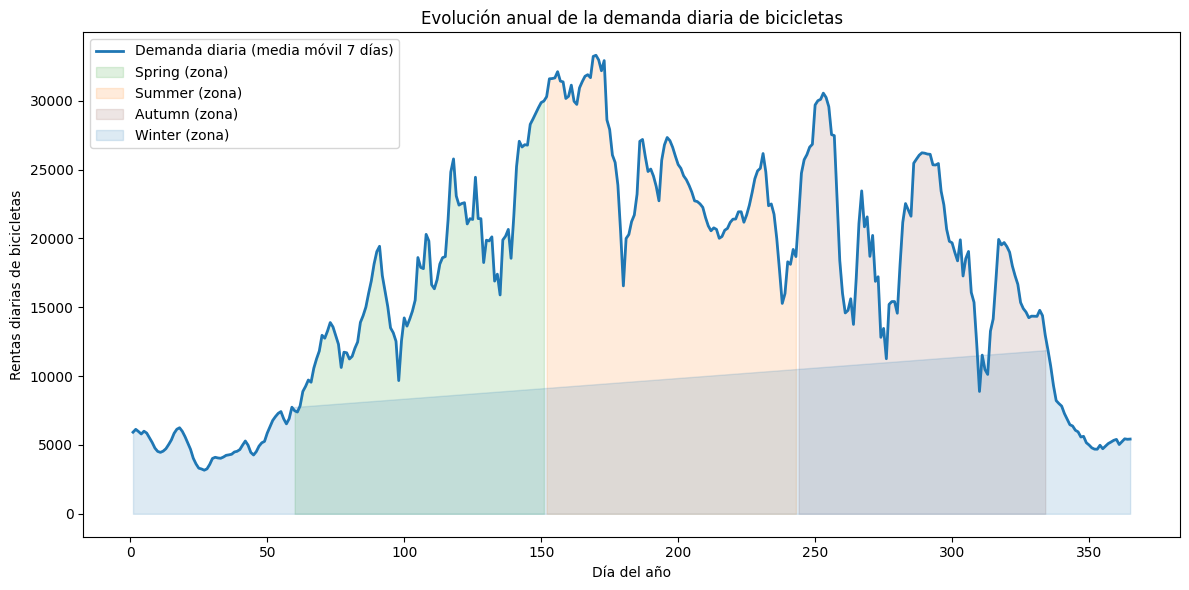

In [22]:

# Asegurarnos de que date es datetime
daily_df["date"] = pd.to_datetime(daily_df["date"])

# Día del año (1–365)
daily_df["day_of_year"] = daily_df["date"].dt.dayofyear

# Ordenamos por día del año
daily_ordered = daily_df.sort_values("day_of_year").copy()

# Media móvil (rolling) para suavizar la curva, por ejemplo ventana de 7 días
daily_ordered["daily_rentals_smooth"] = (
    daily_ordered["daily_rentals"]
    .rolling(window=7, center=True, min_periods=1)
    .mean()
)

# Colores por estación (usar nombres válidos)
season_colors = {
    "Spring": "tab:green",
    "Summer": "tab:orange",
    "Autumn": "tab:brown",
    "Winter": "tab:blue",
}

plt.figure(figsize=(12, 6))

# Curva suavizada completa
plt.plot(
    daily_ordered["day_of_year"],
    daily_ordered["daily_rentals_smooth"],
    label="Demanda diaria (media móvil 7 días)",
    linewidth=2,
)

# Pintar el fondo por estación (zona bajo la curva)
for season, color in season_colors.items():
    mask = daily_ordered["seasons"] == season
    if mask.any():
        plt.fill_between(
            daily_ordered.loc[mask, "day_of_year"],
            daily_ordered.loc[mask, "daily_rentals_smooth"],
            alpha=0.15,
            label=f"{season} (zona)",
            color=color,
        )

plt.xlabel("Día del año")
plt.ylabel("Rentas diarias de bicicletas")
plt.title("Evolución anual de la demanda diaria de bicicletas")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


### Lectura exploratoria de la curva anual

La curva suavizada de demanda diaria a lo largo del año revela algo más rico que un simple “verano alto / invierno bajo”:

- El **pico de uso no aparece de golpe en verano**, sino que empieza a formarse **al final de primavera** y se consolida en el **inicio de verano**. En el borde Spring–Summer se ve un repunte muy marcado, como si el sistema “despegara” justo cuando el clima se vuelve suficientemente agradable.

- Dentro del propio **verano** no hay una meseta perfecta, sino varios **picos y valles intermedios**:
  - Tras el despegue inicial, la demanda alcanza niveles muy altos pero luego presenta caídas temporales y nuevos repuntes.
  - Esto sugiere episodios específicos (por ejemplo, periodos de lluvia, olas de calor, o cambios en el patrón laboral/vacacional) más que un comportamiento plano durante toda la estación.

- Algo similar ocurre en **otoño**: el nivel general es más bajo que en verano, pero aún se observan **repuntes locales** antes de entrar en el descenso más claro hacia invierno. El borde Summer–Autumn no es un corte limpio: hay un tramo en el que el sistema sigue comportándose “casi como verano” y luego empieza a estabilizarse hacia valores más bajos.

- **Invierno**, aunque es el valle absoluto, parece relativamente **más estable**: los niveles son bajos y las oscilaciones, aunque presentes, son menos dramáticas que en verano. Esto encaja con la idea de que el mal clima generalizado (frío, nieve, menos radiación) mantiene la demanda en un rango reducido.

- **Primavera** se ve más “caótica”: parte desde el fondo invernal y va encadenando picos y valles mientras asciende. Es razonable pensar que en esta fase de transición el sistema es especialmente sensible a:
  - cambios bruscos de clima (rachas de lluvia vs días muy agradables),
  - y a la combinación de días laborales, fines de semana y posibles días festivos.

En conjunto, la curva sugiere que, además del efecto de las estaciones, existen **patrones de menor escala** que generan picos y valles dentro de cada estación. Tres candidatos obvios para explicar esas oscilaciones son:

1. **El ciclo semanal** (días laborales vs fines de semana), dado que una parte importante de la demanda parece estar ligada a movilidad por trabajo.
2. **Episodios climáticos concretos** (rachas de lluvia, olas de calor o de frío) que podrían correlacionarse con caídas o subidas puntuales en la demanda.
3. **Días festivos o de azueto**, que pueden alterar el patrón habitual de uso (menos desplazamientos al trabajo, pero posiblemente más uso recreativo en ciertos contextos).

Los siguientes pasos naturales del análisis serían:
- Separar la demanda por **día de la semana** y por **variable `holiday`**, para ver hasta qué punto los picos y valles dentro de cada estación se explican por el calendario laboral y los festivos.
- Revisar, en algunos valles y picos concretos, las condiciones climáticas asociadas (temperatura, lluvia, viento, visibilidad) para comprobar si ciertos episodios meteorológicos extremos coinciden con desviaciones claras respecto al nivel “esperado” de la estación.


In [23]:
# Asegúrate de que date es datetime
daily_df["date"] = pd.to_datetime(daily_df["date"])

# 1. WEEKEND: sábado (5) y domingo (6)
daily_df["weekday"] = daily_df["date"].dt.dayofweek  # 0=lun ... 6=dom
daily_df["is_weekend"] = daily_df["weekday"] >= 5

# 2. HOLIDAY: lo traemos desde bikes_df a nivel diario
#    Ajusta esta parte según cómo tengas codificada la columna 'holiday':
#    - Si es 'Holiday' / 'No Holiday' (string) usamos .eq('Holiday')
#    - Si ya es booleana, puedes hacer .max() directamente.
holiday_daily = (
    bikes_df
    .groupby("date")["holiday"]
    .apply(lambda s: (s == "Holiday").any())  # o .max() si es bool
    .rename("is_holiday")
    .reset_index()
)

# 3. Unimos la info de holiday a daily_df
daily_df = daily_df.merge(holiday_daily, on="date", how="left")

# 4. Resumen: fines de semana vs resto
weekend_summary = (
    daily_df
    .groupby("is_weekend")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
)

print("🔹 Demanda diaria: fines de semana vs días laborales")
display(weekend_summary)

# 5. Resumen: días festivos vs no festivos
holiday_summary = (
    daily_df
    .groupby("is_holiday")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
)

print("\n🔹 Demanda diaria: días festivos vs no festivos")
display(holiday_summary)

# (Opcional) combinar ambos en un "day_type"
def classify_day(row):
    if row["is_holiday"]:
        return "holiday"
    elif row["is_weekend"]:
        return "weekend"
    else:
        return "weekday"

daily_df["day_type"] = daily_df.apply(classify_day, axis=1)

daytype_summary = (
    daily_df
    .groupby("day_type")["daily_rentals"]
    .agg(["count", "mean", "median", "min", "max"])
    .round(2)
    .sort_values("mean", ascending=False)
)

print("\n🔹 Demanda diaria según tipo de día (weekday / weekend / holiday)")
display(daytype_summary)


🔹 Demanda diaria: fines de semana vs días laborales


,count,mean,median,min,max
is_weekend,,,,,
False,261,17266.77,19082.0,0,36149
True,104,16016.21,16458.5,0,34360



🔹 Demanda diaria: días festivos vs no festivos


,count,mean,median,min,max
is_holiday,,,,,
False,347,17165.47,18363.0,0,36149
True,18,11994.17,6158.0,0,30498



🔹 Demanda diaria según tipo de día (weekday / weekend / holiday)


,count,mean,median,min,max
day_type,,,,,
weekday,247,17487.24,19180.0,0,36149
weekend,100,16370.71,17134.0,0,34360
holiday,18,11994.17,6158.0,0,30498


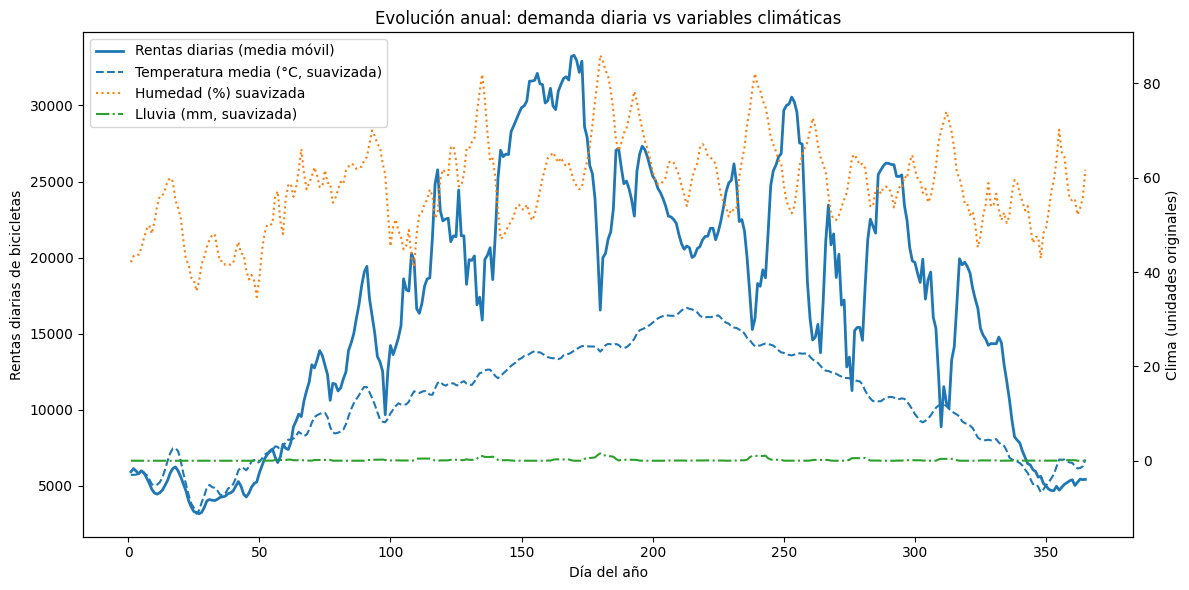

In [24]:
# Asegúrate de que date es datetime y day_of_year está creado
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df["day_of_year"] = daily_df["date"].dt.dayofyear

daily_ordered = daily_df.sort_values("day_of_year").copy()

# Suavizados (media móvil) para demanda y clima
window = 7  # puedes probar 7, 14, etc.

daily_ordered["daily_rentals_smooth"] = (
    daily_ordered["daily_rentals"]
    .rolling(window=window, center=True, min_periods=1)
    .mean()
)

for col in ["temperature°c", "humidity", "rainfallmm"]:
    daily_ordered[f"{col}_smooth"] = (
        daily_ordered[col]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

# Gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje 1: demanda
ax1.plot(
    daily_ordered["day_of_year"],
    daily_ordered["daily_rentals_smooth"],
    label="Rentas diarias (media móvil)",
    linewidth=2,
)

ax1.set_xlabel("Día del año")
ax1.set_ylabel("Rentas diarias de bicicletas")

# Eje 2: clima
ax2 = ax1.twinx()

ax2.plot(
    daily_ordered["day_of_year"],
    daily_ordered["temperature°c_smooth"],
    linestyle="--",
    label="Temperatura media (°C, suavizada)",
)
ax2.plot(
    daily_ordered["day_of_year"],
    daily_ordered["humidity_smooth"],
    linestyle=":",
    label="Humedad (%) suavizada",
)
ax2.plot(
    daily_ordered["day_of_year"],
    daily_ordered["rainfallmm_smooth"],
    linestyle="-.",
    label="Lluvia (mm, suavizada)",
)

ax2.set_ylabel("Clima (unidades originales)")

# Leyenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("Evolución anual: demanda diaria vs variables climáticas")
plt.tight_layout()
plt.show()


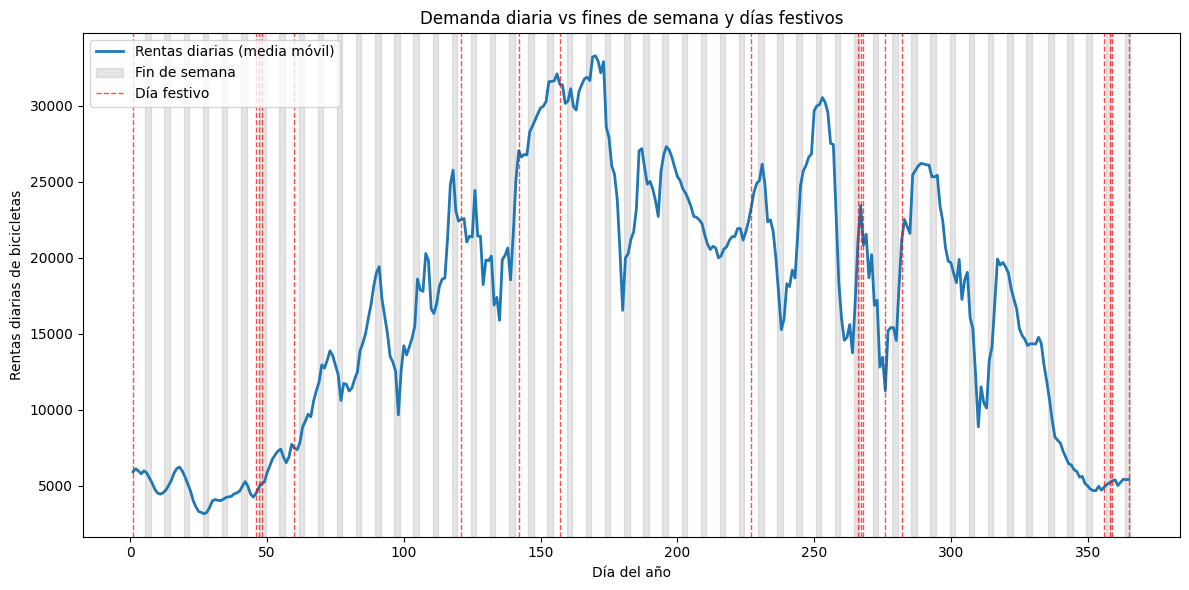

In [25]:
import matplotlib.pyplot as plt

# Asegúrate de que date y day_of_year existen y de que tienes is_weekend / is_holiday
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df["day_of_year"] = daily_df["date"].dt.dayofyear

daily_ordered = daily_df.sort_values("day_of_year").copy()

# Suavizado de la demanda (si no lo tienes ya)
window = 7
daily_ordered["daily_rentals_smooth"] = (
    daily_ordered["daily_rentals"]
    .rolling(window=window, center=True, min_periods=1)
    .mean()
)

fig, ax = plt.subplots(figsize=(12, 6))

# --- Curva de demanda ---
ax.plot(
    daily_ordered["day_of_year"],
    daily_ordered["daily_rentals_smooth"],
    label="Rentas diarias (media móvil)",
    linewidth=2,
    color="tab:blue",
)

# --- Bandas de fines de semana (agrupando sábado+domingo) ---
weekend_days = sorted(
    daily_ordered.loc[daily_ordered["is_weekend"], "day_of_year"].unique()
)

weekend_ranges = []
start = None
prev = None

for d in weekend_days:
    if start is None:
        start = d
        prev = d
    elif d == prev + 1:
        prev = d
    else:
        weekend_ranges.append((start, prev))
        start = d
        prev = d

if start is not None:
    weekend_ranges.append((start, prev))

first_weekend = True
for start, end in weekend_ranges:
    ax.axvspan(
        start - 0.5,
        end + 0.5,
        color="grey",
        alpha=0.2,          # ajusta si quieres más/menos intensidad
        zorder=0,
        label="Fin de semana" if first_weekend else None,
    )
    first_weekend = False

# --- Líneas para días festivos ---
holiday_days = sorted(
    daily_ordered.loc[daily_ordered["is_holiday"], "day_of_year"].unique()
)

first_holiday = True
for d in holiday_days:
    ax.axvline(
        d,
        color="red",
        linestyle="--",
        alpha=0.7,
        linewidth=1,
        label="Día festivo" if first_holiday else None,
    )
    first_holiday = False

ax.set_xlabel("Día del año")
ax.set_ylabel("Rentas diarias de bicicletas")
ax.set_title("Demanda diaria vs fines de semana y días festivos")

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


## Conclusiones del análisis exploratorio

### 1. Estacionalidad anual y forma general de la demanda

La curva anual suavizada de rentas diarias, segmentada por estaciones, confirma que:

- **Verano** es la estación de máxima demanda: concentra los niveles más altos de uso y buena parte de los picos más pronunciados.
- **Invierno** es el valle claro del año: la demanda cae a sus mínimos y se mantiene relativamente baja y estable.
- **Primavera y otoño** funcionan como estaciones de transición:
  - Primavera arranca desde el valle invernal y va encadenando picos y valles mientras asciende.
  - Otoño parte desde niveles altos (heredados de verano) y va descendiendo de forma gradual.

La curva no crece ni decrece de forma lineal; aparece un patrón de **“dientes de sierra”** donde:

- El **borde primavera–verano** muestra un despegue bastante brusco: el uso comienza a dispararse ya al final de la primavera y se consolida en los primeros días de verano.
- Dentro del propio verano hay **picos y valles intermedios**, lo que sugiere episodios específicos (clima, calendario, etc.) más que una meseta continua.
- Hacia el **borde verano–otoño** se observan todavía algunos repuntes antes del descenso más claro.
- El **invierno** parece el tramo más estable: la demanda se mueve en un rango bajo con oscilaciones menos dramáticas.

En conjunto, la estacionalidad domina la forma general, pero los dientes de sierra indican que hay factores de menor escala (clima diario, calendario, etc.) modulando el comportamiento.

---

### 2. Demanda diaria frente a variables climáticas

El gráfico combinado de **rentas diarias vs temperatura, humedad y lluvia** (todas suavizadas) muestra que:

- La **temperatura media** es la variable que más claramente sigue el perfil de la demanda:
  - A medida que la temperatura sube desde los valores invernales, la demanda crece.
  - Cuando la temperatura alcanza valores muy agradables (primavera avanzada y verano), la demanda entra en su zona alta.
  - El descenso gradual de temperatura en otoño acompaña también el descenso progresivo de la demanda.

- La **humedad** no se ajusta tan limpiamente a la curva de rentas, pero:
  - Se observan varios casos en los que **picos de humedad coinciden con valles de demanda**.
  - Esto sugiere que días “pesados” o muy húmedos pueden desincentivar el uso de la bicicleta, incluso cuando la temperatura por sí sola sería aceptable.

- La **lluvia** aparece más discreta:
  - En general, el nivel de lluvia diaria es bajo o presenta episodios relativamente cortos.
  - Sí se aprecian algunos tramos donde aumentos de lluvia coinciden con caídas en la demanda, pero el efecto es menos dominante que el de la temperatura y más intermitente.
  - La lluvia se asocia también a aumentos de humedad, algo esperable y consistente.

En resumen, el **clima** y, en particular, la **temperatura** parecen explicar gran parte de la estructura global de la demanda, mientras que la humedad y la lluvia actúan como moduladores que ayudan a entender ciertos valles y desviaciones locales respecto al patrón estacional.

---

### 3. Demanda diaria frente a fines de semana y días festivos

Al superponer la curva de demanda con franjas de **fines de semana** y líneas para **días festivos**, se observa que:

- Los **fines de semana** generan algunos valles locales, pero el patrón visual no es tan claro ni tan regular como para afirmar un efecto fuerte:
  - Hay fines de semana que coinciden con descensos, otros con incrementos y otros en los que la curva se mantiene relativamente estable.
  - A simple vista, los fines de semana parecen tener un efecto **moderado o variable**, posiblemente compensado por usos recreativos en ciertos periodos (por ejemplo, en verano).

- Los **días festivos** (especialmente cuando se agrupan varios seguidos) parecen estar más asociados a cambios visibles:
  - Se aprecian incrementos ligeros al inicio y al final del año coincidiendo con festivos agrupados.
  - En otoño se perciben algunos **picos muy concentrados** que coinciden con días festivos específicos, lo que sugiere que ciertos feriados podrían disparar el uso (ya sea recreativo o asociado a eventos concretos).
  - No obstante, esta impresión es aún **visual**; para confirmarla haría falta contrastar estos picos con otros momentos del año mediante pruebas estadísticas específicas.

En conjunto, el calendario laboral/festivo sí deja huella en la curva:  
los fines de semana parecen menos determinantes que las **fechas festivas**, que en algunos periodos se alinean con variaciones bruscas de la demanda.

---

### 4. Síntesis y alcance del análisis

Tomando todos los elementos en conjunto (estaciones, clima, fines de semana y festivos), el EDA sugiere que:

- La **estacionalidad y la temperatura** dan la forma global del año: verano como pico, invierno como valle y estaciones de transición con comportamiento intermedio.
- Las **variables climáticas diarias** (humedad, lluvia y, en menor medida, viento y visibilidad, analizados en secciones previas) explican parte de los picos y valles locales, sobre todo cuando se combinan episodios de alta humedad o lluvia con descensos en la demanda.
- El **calendario** introduce estructura adicional:
  - Fines de semana: efecto visible pero no tan sistemático.
  - Días festivos: potencialmente asociados a cambios bruscos en ciertas épocas del año, aunque por ahora solo se han identificado a nivel exploratorio.

Este EDA no pretende establecer causalidad, pero sí ofrece un mapa razonablemente claro de **cuándo** se usan más las bicicletas y **en qué condiciones** (climáticas y de calendario) la demanda se intensifica o se debilita. A partir de aquí, los siguientes pasos naturales serían:

- Formalizar algunas de estas observaciones con **pruebas de hipótesis adicionales** (por ejemplo, días festivos vs no festivos, fines de semana vs laborales en distintas estaciones).
- Explorar modelos más formales (regresiones o modelos no supervisados) que integren simultáneamente clima, calendario y estación para evaluar qué combinación de factores explica mejor la variabilidad en la demanda.